## **NASNetLarge Model**

### **1. Import the necessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dropout,
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras_tuner import RandomSearch

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**

In [2]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Building NasNetLarge Model**


In [3]:
def create_nasnetlarge_model(hp):
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    dropout_rate = hp.Choice("dropout_rate", values=[0.0, 0.2, 0.5])
    dense_units = hp.Choice("dense_units", values=[128, 256, 512]) 
    optimizer_type = hp.Choice(
        "optimizer", values=["adam"]
    )  # adam best, so sgd and rmsprop are not used

    # Load NASNetLarge base model without top layers
    base_model = tf.keras.applications.NASNetLarge(
        weights="imagenet",  # Load weights pre-trained on ImageNet
        include_top=False,
        input_shape=(331, 331, 3),
    )

    # Freeze base model layers
    base_model.trainable = False

    # Create new model on top
    model = Sequential()
    model.add(base_model)

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation="relu"))
    model.add(BatchNormalization())

    model.add(Dense(4, activation="softmax"))

    # Experiment with different optimizers
    # if optimizer_type == "adam":
    #     optimizer = Adam(learning_rate=learning_rate)
    # elif optimizer_type == "sgd":
    #     optimizer = SGD(learning_rate=learning_rate)
    # else:
    #     optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **4. Train Model**

In [4]:
# Hyperparameter tuner setup
tuner = RandomSearch(
    create_nasnetlarge_model,
    objective="val_accuracy",
    max_trials=27,  # 27 possible combinations
    executions_per_trial=1,
    directory="tuner_results",
    project_name="nasnetlarge_tuning",
)

# Initialize dictionary to store models and histories
models = {}

n_splits = 5
epochs = 300

# Iterate over K-fold splits
for fold in range(n_splits):
    print(f"Fold {fold + 1}")

    # Define paths for current fold
    train_dir = f"kfold_dataset_331/train_fold_{fold}"
    val_dir = f"kfold_dataset_331/val_fold_{fold}"

    # ImageDataGenerator for data normalization
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(331, 331),
        batch_size=16,
        class_mode="categorical",
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(331, 331),
        batch_size=16,
        class_mode="categorical",
        shuffle=False,
    )

    # Perform hyperparameter tuning
    tuner.search(
        train_generator,
        epochs=35,
        validation_data=val_generator,
    )

    # Retrieve best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(
        f"Fold {fold + 1} - Best Hyperparameters: learning_rate={best_hps.get('learning_rate')}, dropout_rate={best_hps.get('dropout_rate')}, dense_units={best_hps.get('dense_units')}, optimizer={best_hps.get('optimizer')}"
    )

    # Build the model with the best hyperparameters and train it
    model = tuner.hypermodel.build(best_hps)

    checkpoint_callback = ModelCheckpoint(
        filepath=f"nasnetlarge_fold_{fold}.h5",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    early_stopping_callback = EarlyStopping(
        monitor="val_accuracy",
        patience=30,
        restore_best_weights=True,
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1,
    )

    # Evaluate and store model performance
    val_accuracy = max(history.history["val_accuracy"])
    val_loss = min(history.history["val_loss"])

    # Predict labels for validation set
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_generator.classes

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    models[fold] = {
        "model": model,
        "history": history.history,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
        "conf_matrix": conf_matrix,
    }

# Save the best model
best_model_fold = max(models, key=lambda k: models[k]["val_accuracy"])
models[best_model_fold]["model"].save("best_nasnetlarge_model.h5")

Trial 27 Complete [00h 03m 11s]
val_accuracy: 0.875

Best val_accuracy So Far: 0.90625
Total elapsed time: 01h 31m 23s
Fold 2 - Best Hyperparameters: learning_rate=0.01, dropout_rate=0.5, dense_units=512, optimizer=adam
Epoch 1/300
24/24 [==============================] - ETA: 0s - loss: 1.5557 - accuracy: 0.5521
Epoch 1: val_accuracy improved from -inf to 0.57292, saving model to nasnetlarge_fold_1.h5
24/24 [==============================] - 17s 389ms/step - loss: 1.5557 - accuracy: 0.5521 - val_loss: 3.0845 - val_accuracy: 0.5729
Epoch 2/300
24/24 [==============================] - ETA: 0s - loss: 0.8444 - accuracy: 0.6536
Epoch 2: val_accuracy improved from 0.57292 to 0.68750, saving model to nasnetlarge_fold_1.h5
24/24 [==============================] - 6s 257ms/step - loss: 0.8444 - accuracy: 0.6536 - val_loss: 1.3107 - val_accuracy: 0.6875
Epoch 3/300
24/24 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.7734
Epoch 3: val_accuracy improved from 0.68750 to 

### **5. Evaluate and Visualize Results**

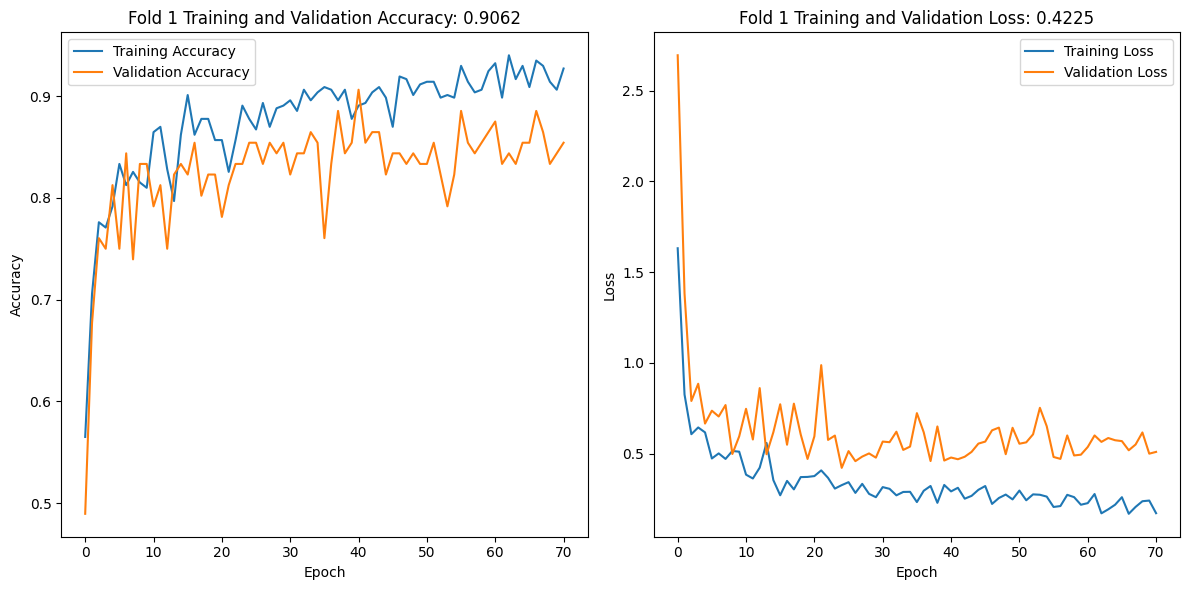

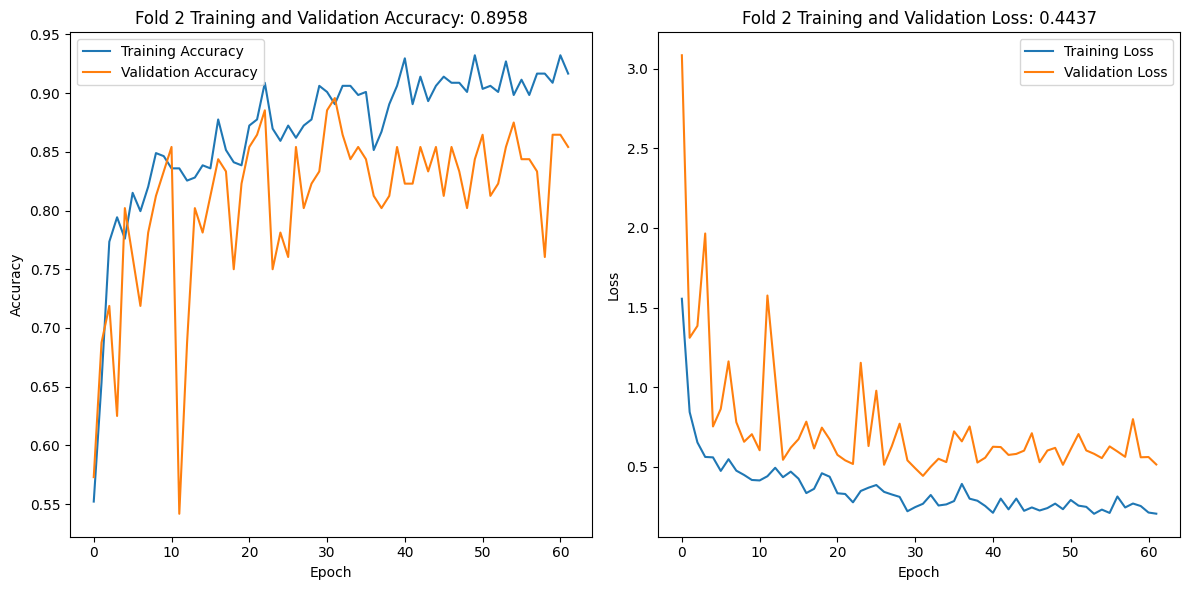

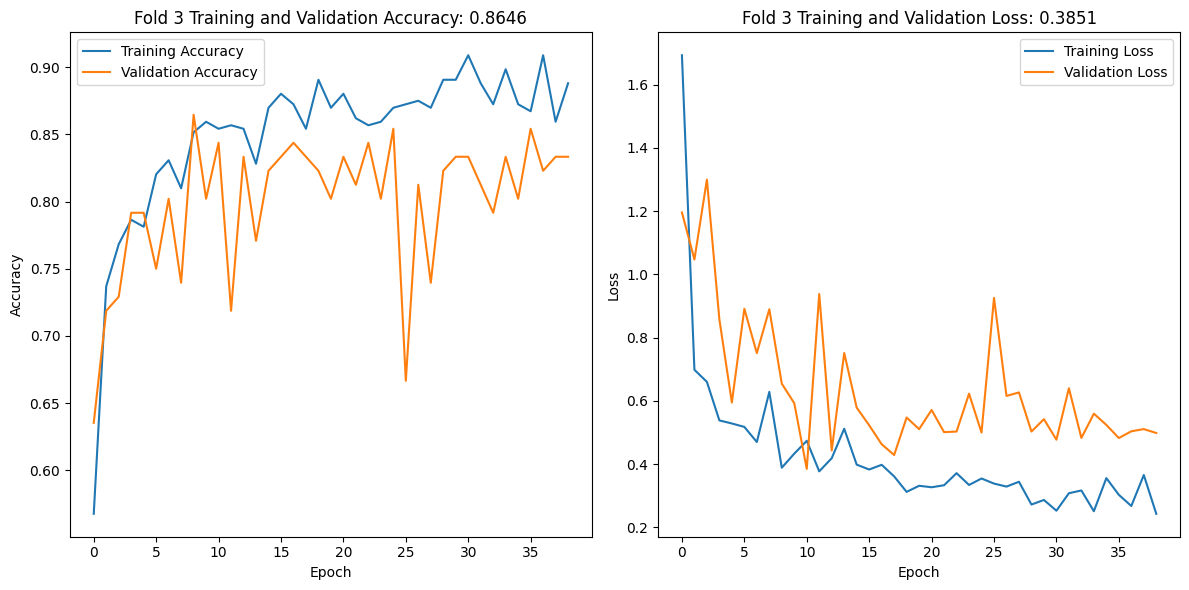

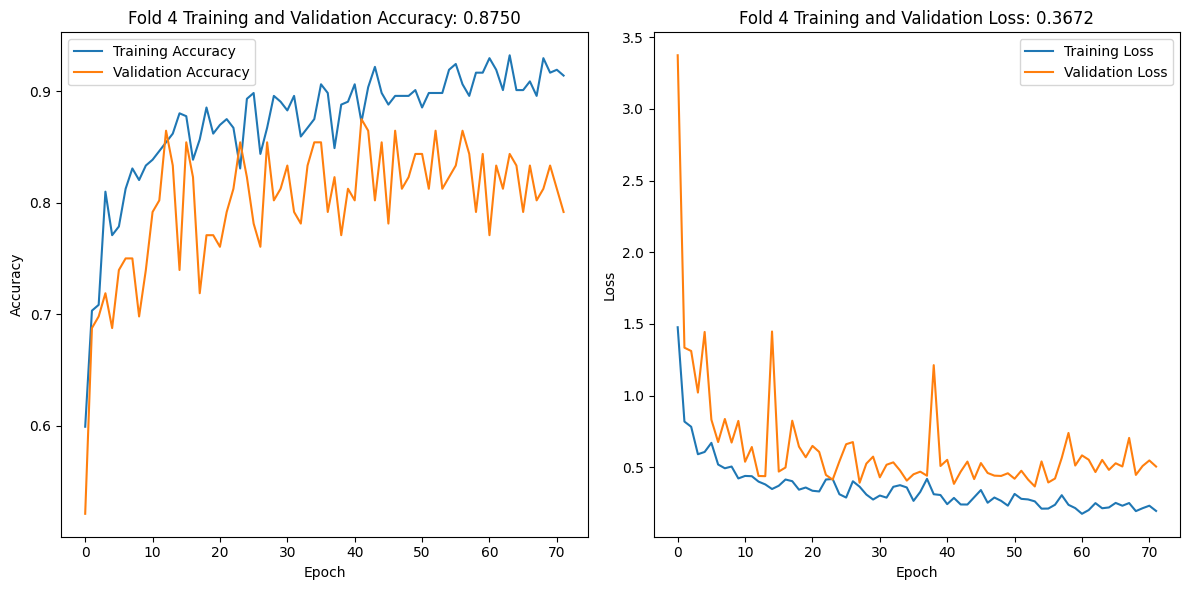

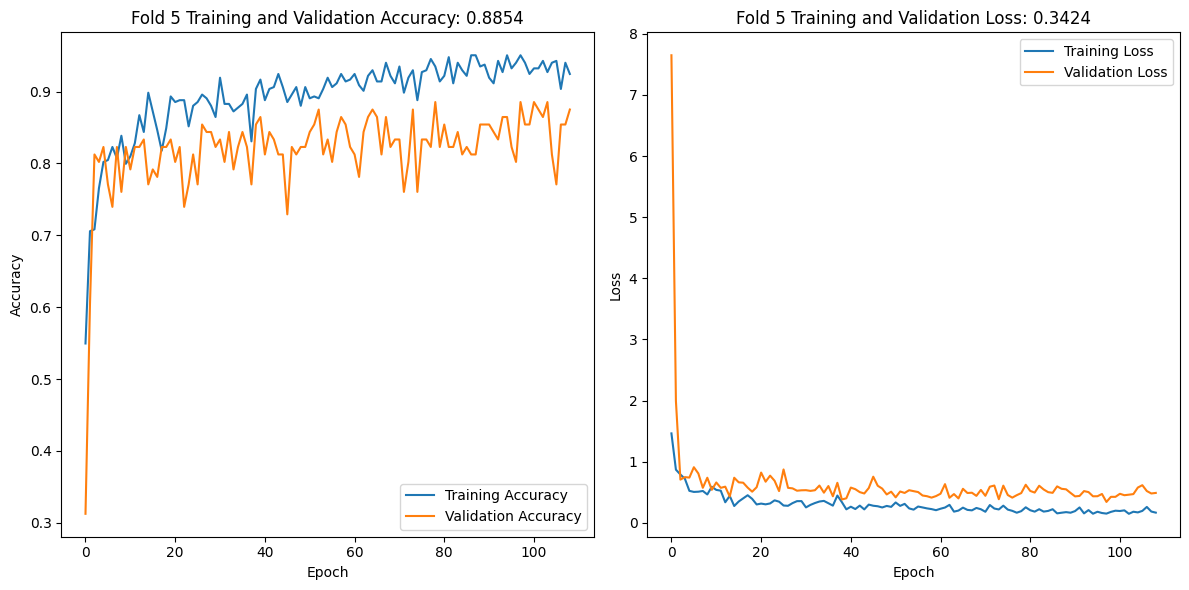

In [5]:
# Plot training history for all folds
for fold, result in models.items():
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(result["history"]["accuracy"], label="Training Accuracy")
    plt.plot(result["history"]["val_accuracy"], label="Validation Accuracy")
    plt.title(
        f"Fold {fold + 1} Training and Validation Accuracy: {result['val_accuracy']:.4f}"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(result["history"]["loss"], label="Training Loss")
    plt.plot(result["history"]["val_loss"], label="Validation Loss")
    plt.title(f"Fold {fold + 1} Training and Validation Loss: {result['val_loss']:.4f}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

Fold 1 - Accuracy: 0.9062 - Loss: 0.4225
Fold 1
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 144ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98        24
  meningioma       0.89      0.71      0.79        24
   pituitary       0.79      0.96      0.87        24
     notumor       0.96      1.00      0.98        24

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.90        96
weighted avg       0.91      0.91      0.90        96



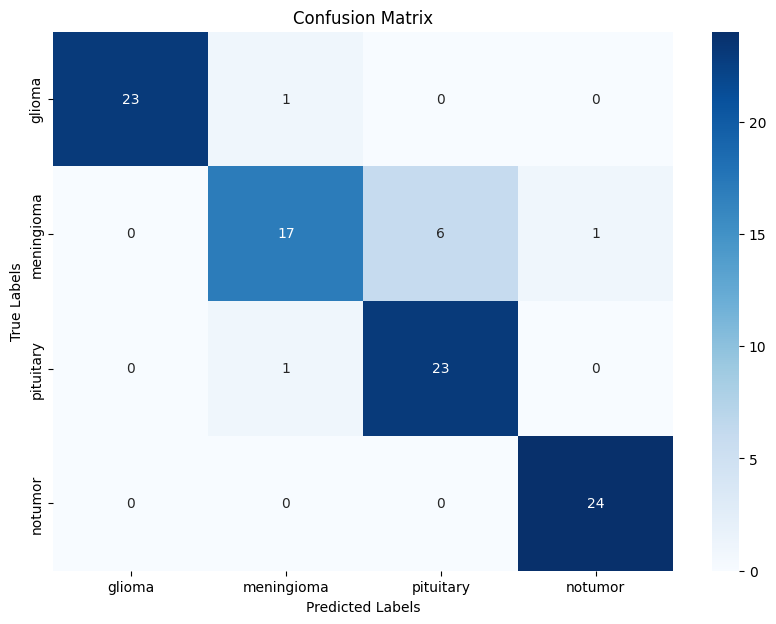

Fold 2 - Accuracy: 0.8958 - Loss: 0.4437
Fold 2
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 119ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.88      0.91        24
  meningioma       0.76      0.92      0.83        24
   pituitary       0.96      0.96      0.96        24
     notumor       0.95      0.83      0.89        24

    accuracy                           0.90        96
   macro avg       0.91      0.90      0.90        96
weighted avg       0.91      0.90      0.90        96



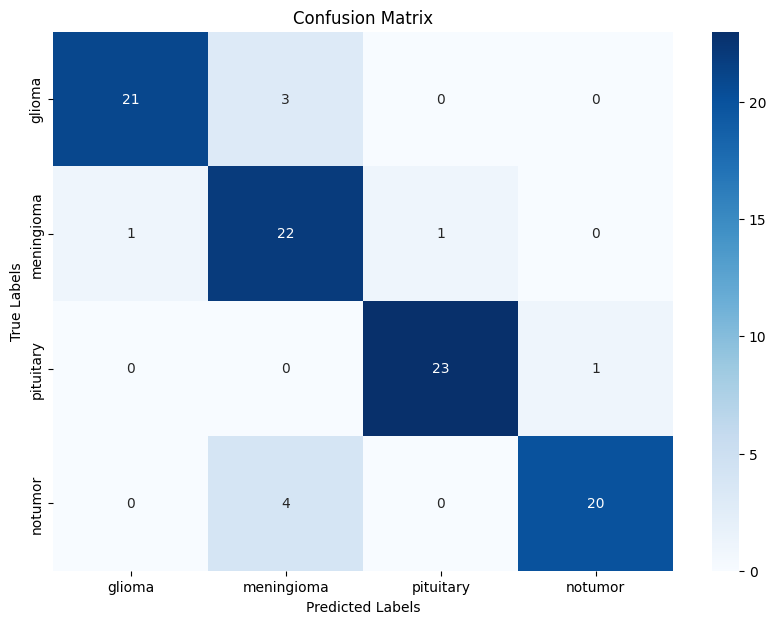

Fold 3 - Accuracy: 0.8646 - Loss: 0.3851
Fold 3
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 120ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.83      0.87        24
  meningioma       0.71      0.92      0.80        24
   pituitary       1.00      0.96      0.98        24
     notumor       0.90      0.75      0.82        24

    accuracy                           0.86        96
   macro avg       0.88      0.86      0.87        96
weighted avg       0.88      0.86      0.87        96



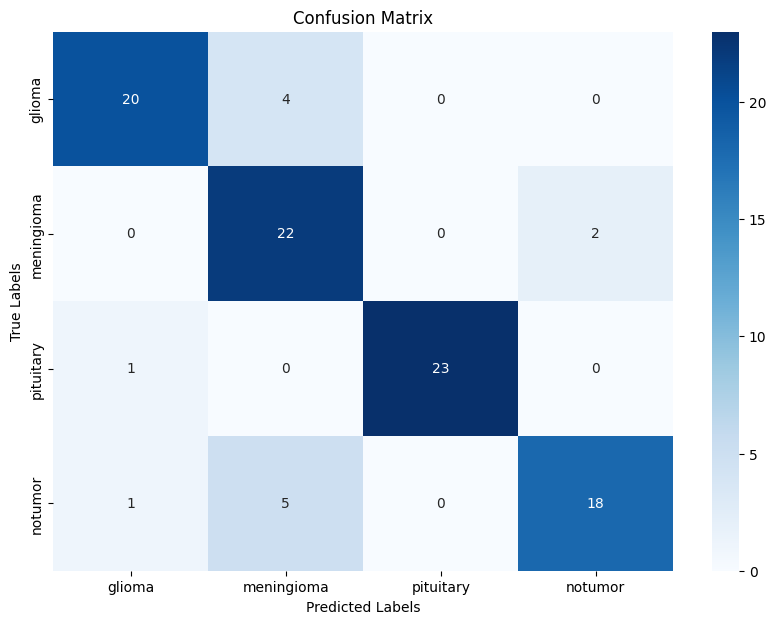

Fold 4 - Accuracy: 0.8750 - Loss: 0.3672
Fold 4
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 120ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.79      0.86        24
  meningioma       0.83      0.79      0.81        24
   pituitary       0.82      0.96      0.88        24
     notumor       0.92      0.96      0.94        24

    accuracy                           0.88        96
   macro avg       0.88      0.88      0.87        96
weighted avg       0.88      0.88      0.87        96



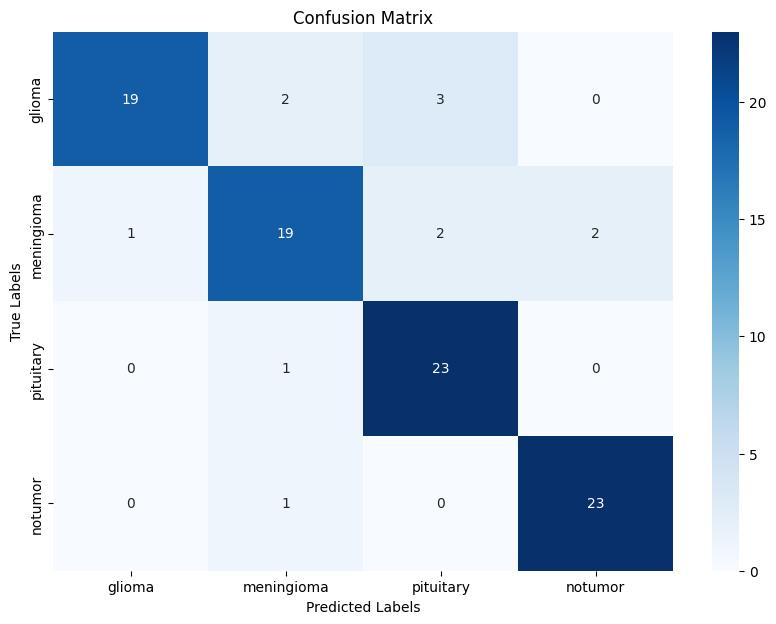

Fold 5 - Accuracy: 0.8854 - Loss: 0.3424
Fold 5
Found 96 images belonging to 4 classes.
6/6 [==============================] - 1s 119ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.87      0.83      0.85        24
  meningioma       0.81      0.88      0.84        24
   pituitary       1.00      0.88      0.93        24
     notumor       0.88      0.96      0.92        24

    accuracy                           0.89        96
   macro avg       0.89      0.89      0.89        96
weighted avg       0.89      0.89      0.89        96



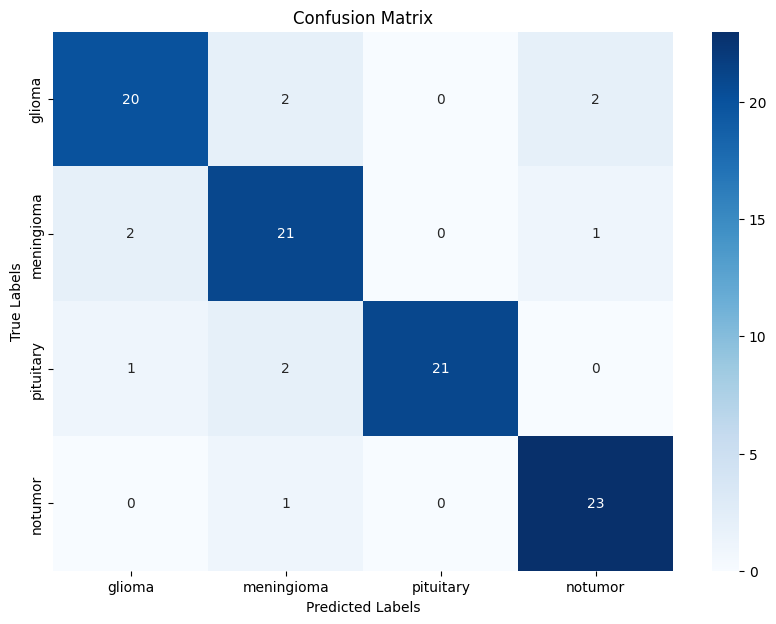

In [6]:
# Load the saved model
image_size = 331
for key, value in models.items():
    accuracy = value["val_accuracy"]
    loss = value["val_loss"]
    model = value["model"]
    print(f"Fold {key + 1} - Accuracy: {accuracy:.4f} - Loss: {loss:.4f}")
    print(f"Fold {key + 1}")

    # Define the paths
    data_dir = "../DATASETS/kfold_dataset_331"
    val_dir = data_dir + f"/val_fold_{key}"

    # ImageDataGenerator for normalization
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Data generator for test set
    test_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(
            image_size,
            image_size,
        ),  # Adjust if your model was trained with a different target size
        batch_size=16,  # Adjust based on your batch size during training
        class_mode="categorical",
        shuffle=False,
    )
    categories = ["glioma", "meningioma", "pituitary", "notumor"]

    # Predict the labels for the test set
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Compute the classification report
    report = classification_report(y_true, y_pred_classes, target_names=categories)
    print("Classification Report:\n")
    print(report)

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=categories,
        yticklabels=categories,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()